# Hackathon 1, statistics.

This project illustrates the statistics part of the course LEPL1109. In the first part of the project, you will study the China water pollution by analyzing a dataset providing the water pollution levels collected from various monitoring stations across 10 major provinces in China throughout the year 2023. In the second part of the project, you will analyze a dataset containing high-frequency time-series  data collected from an industrial boiler operating in a chemical plant.

## Report content

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

•	Do not comment your results directly into cells of code. Use instead a Markdown cell. 

•	"Dry" code or results not followed by a minimum of analysis / comments will be penalized.


## Report submission

•	Deadline, see moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.


## Names and Noma of participants:

Part. 1: Lepoutre Florian - 45122300

Part. 2: Peffer Jean-Louis - 72232300

Part. 3: Schlicker Ulrick - 41982300

Part. 4: Jamblin Otto - 36402301

Part. 5: Thiry John - 45942300

Part. 6: Gangolf Pierre - 40492300

# China Water Pollution 

This dataset provides  water pollution levels collected from various monitoring stations across 10 major provinces in China throughout the year 2023. The data  includes  parameters such as pH, turbidity, chemical and biological oxygen demand, nutrient levels, and heavy metal concentrations. These indicators are widely used by environmental monitoring agencies to assess water quality for ecological, human, and industrial impacts.

We will focus on the Water Quality Index. 

## Imports

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import statsmodels.api as sm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 1. Basic statistics

### 1.a)
Load the dataset 'china_water_pollution_data_hack.csv'. Convert Province, City  to categorical variables. (**0.5 pt**) 

In [3]:
# CSV reading
data = pd.read_csv('./China_water_pollution/china_water_pollution_data_hack.csv')

# Convert to categorical variables
data['Province'] = data['Province'].astype('category')
data['City'] = data['City'].astype('category')

### 1.b)
Calculate the mean, variance, median, 25% and 75% quantiles of the water quality index (which ranges from 0 to 100) for all cities in the dataset. Comment your results! (**1.5 pts**)

In [4]:
# Variable extraction
desc = data.groupby("City", observed=False)["Water_Quality_Index"].describe()   # count, mean, std, min, max, 25%, 50%, 75%
desc["variance"] = desc['std'] ** 2                                             # variance == std ** 2
print(desc[["mean","variance","50%","25%","75%"]])                              # selecting only needed datas

                mean   variance        50%        25%        75%
City                                                            
Beijing    58.882070  24.447735  58.333333  56.070042  61.736875
Chengdu    54.405592  24.594466  54.795208  51.389167  57.267733
Dali       54.181129  31.266031  53.974083  50.662117  58.027806
Guangzhou  58.360981  34.337685  58.319458  54.687812  63.104396
Hangzhou   58.939443  30.310407  58.333333  55.000000  61.715646
Jinan      58.732275  24.629255  58.333333  55.000000  61.819708
Kunming    58.748408  24.475260  59.056500  55.251000  61.666667
Luoyang    53.289280  29.065348  53.238983  49.636475  56.347404
Mianyang   58.752162  29.738358  58.333333  55.000000  63.333333
Nanjing    54.166608  28.179058  53.842825  50.631592  57.835500
Ningbo     58.666299  27.020291  58.263958  55.000000  61.666667
Qingdao    58.393345  24.494630  58.333333  54.840438  61.757271
Shanghai   59.444212  22.332776  59.708625  56.409979  63.175021
Shenzhen   58.984718  27.

### Comments

We have computed the mean, variance, median (50%), and the 25%/75% quantiles based on the given sample. The variance is therefore an estimate computed using the following formula : $s^2 = \frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})^2$

The mean values are more or less the same, between 53 and 60. The standard deviations are low compared to the mean values. It means that the values are regrouped around the mean. We can also see that the median is close to the mean for all cities.

## 2. Hypothesis tests 

### 2.a)
Check with a Student's T test that the average water quality index is the same in Shenzhen and Dali: $$H_0: \mu_{Shenzhen} = \mu_{Dali},\\
H_1: \mu_{Shenzhen} \neq \mu_{Dali}.$$ Calculate all statistics and p-value without recourse to other functions than statistical distributions (use course's formula). Use a confidence level of 5%. Take care to comment your conclusions. Are all assumptions required to perform this test sastisfied? Which additional test do you have to do to validate your result? (**2.5 pts**)

In [5]:
# Variables extraction
n1 = desc.loc["Shenzhen","count"]       # number of data (Shenzhen)
X1bar = desc.loc["Shenzhen","mean"]     # average (Shenzhen)
S1 = desc.loc["Shenzhen","std"]         # variance (Shenzen)

n2 = desc.loc["Dali","count"]           # number of data (Dali)
X2bar = desc.loc["Dali","mean"]         # average (Dali)
S2 = desc.loc["Dali","std"]             # variance (Dali)

df=n1+n2-2      # degrees of liberty


# Calculation of the p-value
Spool = np.sqrt(((n1-1)*(S1**2)+(n2-1)*(S2**2))/(df))   # unbiased "pooled" estimator of the variance

T=((X1bar-X2bar)/(Spool*np.sqrt((1/n1)+(1/n2))))        # statistics of test calculation

pvalue= 2*(1-sc.t.cdf(abs(T),df,loc=0,scale=1))         # p-value
print("pvalue :", pvalue)
print("")

# Are all assumptions verified ?

# We can verify that our datas follows a Normal Distribution
print("Normal Distribution ?")

Shenzhen_data = data[data["City"] == "Shenzhen"]["Water_Quality_Index"]
Dali_data = data[data["City"] == "Dali"]["Water_Quality_Index"]
print("Shenzhen : " + str(sc.shapiro(Shenzhen_data)))
print("Dali : " + str(sc.shapiro(Dali_data)))
print("")


# We can also verify that our datas have the same variance
print("Is sigma1 = sigma2 ?")

# H0 : sigma1 == sigma2
# H1 : sigma1 < sigma2

F=(S1**2)/(S2**2)                                   # statistics of test calculation

pvaluesigma= (sc.f.cdf(abs(F),dfn=n1-1,dfd=n2-1))   # p-value
print("pvalue : " +str(pvaluesigma))

pvalue : 2.475797344914099e-13

Normal Distribution ?
Shenzhen : ShapiroResult(statistic=0.988514414770562, pvalue=0.23501834293248447)
Dali : ShapiroResult(statistic=0.9915554084847528, pvalue=0.5472895706417602)

Is sigma1 = sigma2 ?
pvalue : 0.21260326924228945


### Comments

Our p-value is 2.475797344914099e-13. It means that we can reject $H_0$, which provides support for $H_1$ : the average quality water index is not equal in Shenzhen and in Dali.

The assumptions to perform this test are multiple : independents populations, the datas follow normal distributions and the variances of the two variables are equal.

First of all, we can assume that the two populations are independent because the distance between Shenzhen and Dali is 1800 km.

Then we can check if the two sets of datas follow a normal distribution with a scipy.stats method : sc.shapiro(). It gives us p-values of 0.235 and 0.547, which means that we do not reject the null hypothesis ($H_0$ : the data was drawn from a normal distribution).

Finally, we can check if the variances are equal with : $$H_0 : \sigma_1 = \sigma_2 \\ H_1 : \sigma_1 < \sigma_2$$ We took $H_1 : \sigma_1 < \sigma_2$ because $s_1 < s_2$ and because it was the most logical choice after having computed the statistical test F. Using a Fisher distribution, we get a p-value of 0.21, which means that we do not reject $H_0 : \sigma_1 = \sigma_2$.

### 2.b)
'Wuhan', 'Luoyang', 'Chengdu', 'Nanjing', 'Dali' seems to have similar (and low) water quality index. Test the assumption: $$H_0:  \mu_{Wuhan} = \mu_{Luoyang}= \mu_{Chengdu} = \mu_{Nanjing} =\mu_{Dali}.$$
**Hint**: reformulate the problem as a linear regression.

(**2 pts**)

In [6]:
# cities of interest in this exercice
cities = ["Wuhan","Luoyang","Chengdu","Nanjing","Dali"]                         

# we only select needed columns and we reset the indexes (in order to use pd.get_dummies())
data_subset = data[data["City"].isin(cities)].copy().reset_index(drop=True)

# converting only our cities of interest into categorical variables (in order to use pd.get_dummies())
data_subset["City"] = pd.Categorical(data_subset["City"], categories=cities)

# we create our binary matrix X, for the linear regression
X = pd.get_dummies(data_subset["City"], drop_first=True, dtype="float64")

# Our target variable
Y = data_subset["Water_Quality_Index"]

Xm = sm.add_constant(X) # we add a constant for our linear regression
model = sm.OLS(Y,Xm)    # we compute the OLS model
results=model.fit()     # linear regression

print("p-value :", results.f_pvalue)

p-value : 0.4262199233201662


### Comments

We have reformulated the problem as a linear regression of this form : $$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4$$ with four binary variables of this form
X_i =
\begin{cases}
1 & \text{if Fact. i} \\
0 & \text{otherwise}
\end{cases}
We only use four binary variables in order not to have an ill-posed matrix when we add the linear regression constant.

We then test the following assumption : $$H_0 : \beta_1 = \beta_2 = \beta_3 = \beta_4 = 0 \\ H_1 : \exists i \space tq \space \beta_{i} \neq 0$$

Using the OLS linear regression model, we get a p-value of 0.426, which is greater than alpha = 0.05. It means that we do not reject $H_0:  \mu_{Wuhan} = \mu_{Luoyang}= \mu_{Chengdu} = \mu_{Nanjing} =\mu_{Dali}.$.

## 3. Regressions

### 3.a)
Propose a regression model which explains the Water_Quality_Index as a function of other explanatory variables, **for the city of Shanghai**. Split your data set into a training set (80% of the data) that you use for fitting the model and a test set (20% of the data) on which you test the accuracy of the model. 

* Use the OLS() function of the package statsmodels.api to perform the linear regression. 
* Comment your results (goodness of fit, R2, F-stat and T-stats of coefficients)
* Identify potential non-relevant covariates
* Calculate the MAE on the test and training sets. 

(**3 pts**)

In [7]:
# Variables extraction
shanghai = data[data['City'] == 'Shanghai'].copy()                      # Keep only rows where the 'City' column equals 'Shanghai'
X = shanghai.loc[:,"Water_Temperature_C":"Coliform_Count_CFU_100mL"]    # explanatory variables
y = shanghai['Water_Quality_Index']                                     # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 80% of the data for training, 20% for testing.

X_train_sm = sm.add_constant(X_train)           #Add constant term for OLS regression
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()   #Fit the Ordinary Least Squares (OLS) regression model


#Evaluate model performance using Mean Absolute Error (MAE)
mae_train = np.mean(np.abs(y_train - ols_model.predict(X_train_sm)))  
mae_test = np.mean(np.abs(y_test - ols_model.predict(X_test_sm)))

print(f"MAE (train) = {mae_train:.2f}")
print(f"MAE (test) = {mae_test:.2f}")

print(ols_model.summary()) # Display full statistical summary

MAE (train) = 1.75
MAE (test) = 1.86
                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.773
Model:                             OLS   Adj. R-squared:                  0.757
Method:                  Least Squares   F-statistic:                     49.32
Date:                 Sat, 01 Nov 2025   Prob (F-statistic):           2.65e-65
Time:                         19:06:25   Log-Likelihood:                -549.08
No. Observations:                  249   AIC:                             1132.
Df Residuals:                      232   BIC:                             1192.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### Comments

The model shows a good fit (R² = 0.773, Adj. R² = 0.757, both close to 1). The linear regression is globally significant (F = 49.32, p-value : 2.65e-65 << 0.05). 

The most important predictors are Dissolved Oxygen (positive effect) and Turbidity, Nitrate, Ammonia, and Total Phosphorus (negative effects). 

Some variables (pH, Water Temperature, Nitrite, Total Nitrogen) are not statistically significant (p > 0.05) and could be removed. 

The model achieves low Mean Absolute Error (MAE_train = 1.75, MAE_test = 1.86), indicating strong predictive performance and little overfitting.

However, the large condition number (5.19×10⁴) suggests strong multicollinearity among predictors, meaning that some explanatory variables are highly correlated.

### 3.b)
Same question as 3.a) but now you use a Gaussian process regression. Use a RBF and Matern kernel and compare MAEs of the 2 models. Which one is the best? (**2 pts**)

In [10]:
# RBF kernel
kernel_rbf = RBF()                                                          # kernel initialization
gpr_rbf = GaussianProcessRegressor(kernel=kernel_rbf, random_state=0)       # model initialization
gpr_rbf.fit(X_train, y_train)                                               # fitting with the training datas
y_pred_rbf = gpr_rbf.predict(X_test)                                        # Predict on the test set
mae_rbf = np.mean(np.abs(y_test - y_pred_rbf))                              # Compute the Mean Absolute Error (MAE)

# MAE training set (RBF kernel)
y_pred_rbf_train = gpr_rbf.predict(X_train)                                 # Predict on the training set
mae_rbf_train = np.mean(np.abs(y_train - y_pred_rbf_train))                 # Compute the Mean Absolute Error (MAE)


# Matern kernel
kernel_matern = Matern()                                                        # kernel initialization
gpr_matern = GaussianProcessRegressor(kernel=kernel_matern, random_state=0)     # model initialization
gpr_matern.fit(X_train, y_train)                                                # fitting with the training data
y_pred_matern = gpr_matern.predict(X_test)                                      # Predict on the test set
mae_matern = np.mean(np.abs(y_test - y_pred_matern))                            # Compute the Mean Absolute Error (MAE)

# MAE training set (Matern kernel)
y_pred_matern_train = gpr_matern.predict(X_train)                               # Predict on the training set
mae_matern_train = np.mean(np.abs(y_train - y_pred_matern_train))               # Compute the Mean Absolute Error (MAE)

print(f"MAE RBF (test) = {mae_rbf:.2f}")
print(f"MAE RBF (train) = {mae_rbf_train}")
print("")
print(f"MAE Matern (test) = {mae_matern:.2f}")
print(f"MAE Matern (train) = {mae_matern_train}")

MAE RBF (test) = 8.13
MAE RBF (train) = 6.554772517713546e-09

MAE Matern (test) = 4.83
MAE Matern (train) = 3.660466600067082e-09


### Comments

For the training set, both models achieve an unsignificant MAE, around $10^-9$. However, for the test set, the model using the Matern kernel achieved a lower Mean Absolute Error (MAE = 4.83) compared to the RBF kernel (MAE = 8.13). Therefore, the Gaussian Process model with the Matern kernel performs best. We can see that the linear regression achives a lower MAE for the test set.

# Boiler

![furnace_plotL](boiler/furnace_plotL.PNG)

This dataset contains high-frequency time-series  data collected (every 5 seconds) from an industrial boiler operating in a chemical plant. The boiler is equipped with multiple sensors capturing parameters such as pressure, temperature, flow rate, and oxygen levels. The dataset reflects a real-world industrial scenario. The boiler outlet steam temperature, ranging typically from 530 °C to 545 °C during stable operation, is used as the key indicator of equipment state. Deviations outside this range represent abnormal operating conditions. 

## 4. Poisson Process

During stable operations, the outlet steam temperature is in the interval 530 °C to 545 °C. 

### 4.a)
Load the dataset 'data_boiler.csv', plot the Boiler outlet steam temperature (variable 'TE_8332A.AV_0') and count the number of times this temperature is outside this normal range. What do you observe? (**1 pt**)

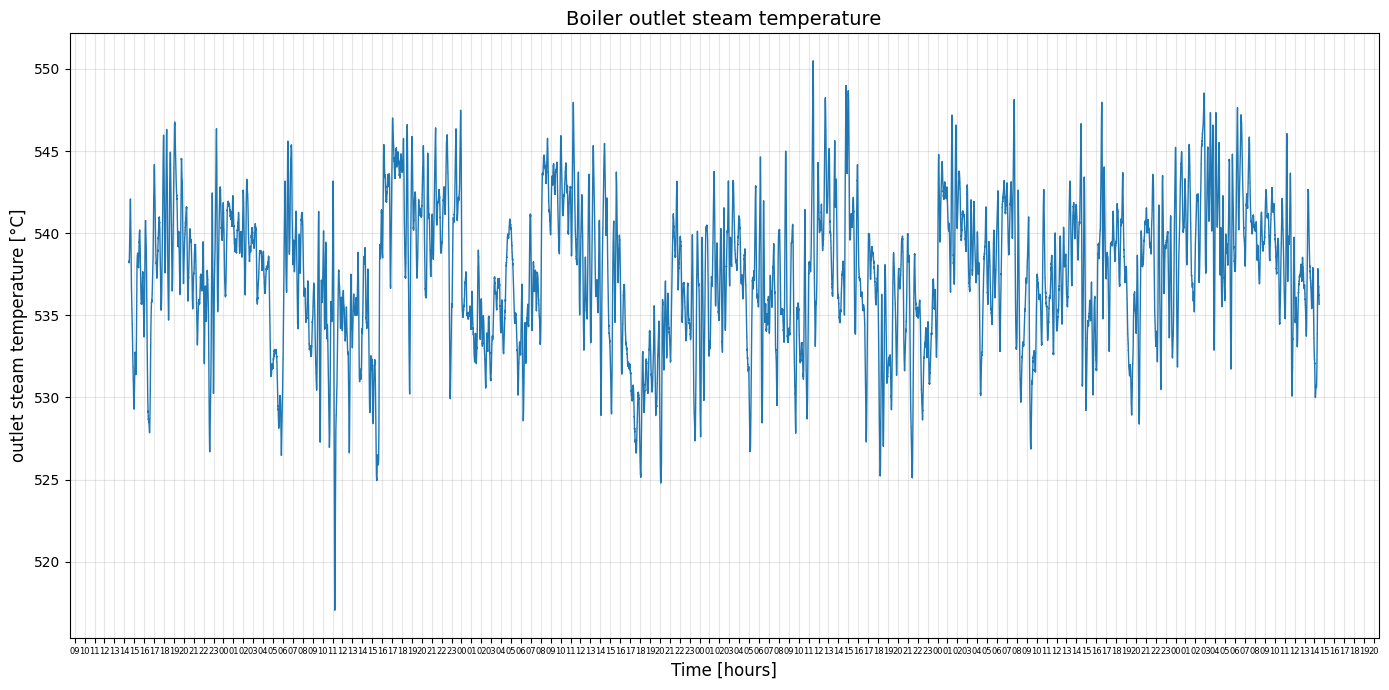

the number of times the boiler is outside its normal temperature range is: 7037
the probability of the boiler to be outside its normal tempurature range is: 0.08144675925925926

the number of times the boiler is inside its normal temperature range is: 79363
the probability of the boiler to be inside its normal tempurature range is: 0.9185532407407407


In [67]:
# CSV reading
data = pd.read_csv('Boiler\data_boiler.csv')
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(df.index,df['TE_8332A.AV_0#'],linewidth=1)

# Format x-axis
ax.set_title('Boiler outlet steam temperature', fontsize=14)
ax.set_xlabel('Time [hours]', fontsize=12)
ax.set_ylabel('outlet steam temperature [°C]', fontsize=12)
ax.grid(True, alpha=0.3)

# Set date format and intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # toute les 1H
plt.xticks( fontsize=6)
plt.tight_layout()

plt.show()

# Counting number of times outside normale range 
temp_val = df['TE_8332A.AV_0#'].tolist()

ntimes_out = 0
for i in range(0,len(temp_val)):
    if ((temp_val[i] > 545) or (temp_val[i] < 530)):
        ntimes_out += 1

#esperance of finding outside its normal temp range
prob_out = ntimes_out/len(temp_val)

print(f"the number of times the boiler is outside its normal temperature range is: {ntimes_out}")
print(f"the probability of the boiler to be outside its normal tempurature range is: {prob_out}")
print("")


#number of times and esperance of finding inside normal range
ntimes_in = len(temp_val) - ntimes_out
prob_in = ntimes_in/len(temp_val)

print(f"the number of times the boiler is inside its normal temperature range is: {ntimes_in}")
print(f"the probability of the boiler to be inside its normal tempurature range is: {prob_in}")

### Comments

We can observe that the number of times the boiler is outside its normal temperature range is 7037, this is low compared to the number of times it is inside its normal tempurature range, the probabilities of finding a temperature outside its normal range on the whole period of time is 0.082 and finding it inside its normal range is 0.918.

### 4.b)
A Poisson process, denoted by $N_t$ is a counting process. The number of events observed during an interval [0,t] is distributed according to a Poisson law with a parameter $\lambda \times t$. Using the method of moment, estimate $\lambda \times t$, the frequency of overheating **or** underheating (i.e. when we are outside the interval) per hour.

Remark: do not forget that time-series data are collected every 5 seconds.

(**1.5 pt**)

In [68]:
time_T = (len(temp_val)*5)/3600
lamba_out = ntimes_out /time_T 
print(f"parametre lambda_out is: {lamba_out}")
lamba_in = ntimes_in/time_T
print(f"parametre lambda_in is: {lamba_in}")

parametre lambda_out is: 58.641666666666666
parametre lambda_in is: 661.3583333333333


### 4.c)
Calculate the probability of observing more ( >= ) than 50 abnormal temperatures on 1h. (**1 pt**)

In [69]:
#P(X >= 50) = (1 - P(X <= 49))

# Probability of observing more than 50 abnormal temperatures on 1h
pless49 = sc.poisson.cdf(49,lamba_out)      # P(X <= 49)
pmore50 = 1 - pless49                       # P(X >= 50)

# Probability of observing more than 50 normal temperatures on 1h
notpmore49 = 1 - sc.poisson.cdf(49,lamba_in)    # P(X >= 50)

print(f"probability of observing more ( >= ) than 50 abnormal temperatures on 1h: {pmore50}")
print(f"probability of observing more ( >= ) than 50 normal temperatures on 1h: {notpmore49}")

probability of observing more ( >= ) than 50 abnormal temperatures on 1h: 0.8858156859855504
probability of observing more ( >= ) than 50 normal temperatures on 1h: 1.0


### Comments

At first we can think that the probability of observing more than 50 abnormal temperature in 1h (0.88) is very high and that it would suggest that the boiler is not stable in the short term. But comparing it to the probability of observing more than 50 normal temperatures in 1h (probability of 1) suggest otherwise that the boiler is stable in the short term, we conclude this because the boiler will not be staying a long time in a abnormal temperature range, it will quickly come back to a normal temperature range. Furthermore by compraing the paramatres $\lambda_{1} = 58.64$ (the frequency of overheating **or** underheating per hour) and $\lambda_2 = 661$ (the frequency of no overheating **and** underheating (i.e. when we are inside the interval) per hour) we can see that most of the time the boiler is inside it's normal temperature range. 

## 5. Fit of distributions and forecasting 

The induced draft fan motor current must in normal condition stay below 30 Amp. A current above 30 Amp may cause damage to the installation. 

### 5.a)
Fit a Gamma and an exponentiated Weibull distributions to the variable YFJ3_AI.AV_0. Compare histograms and  densities, and choose the most appropriate distribution. Using the most appropriate distribution, determine the probability that over a similar period of time, we observe a peak of induced draft fan motor current above 30 Amp. 
(**3 pts**)

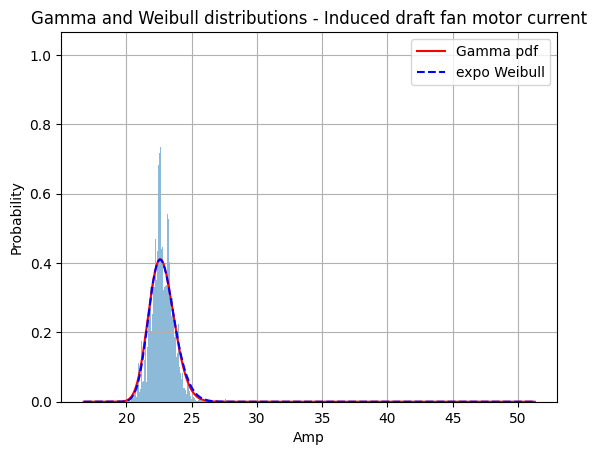

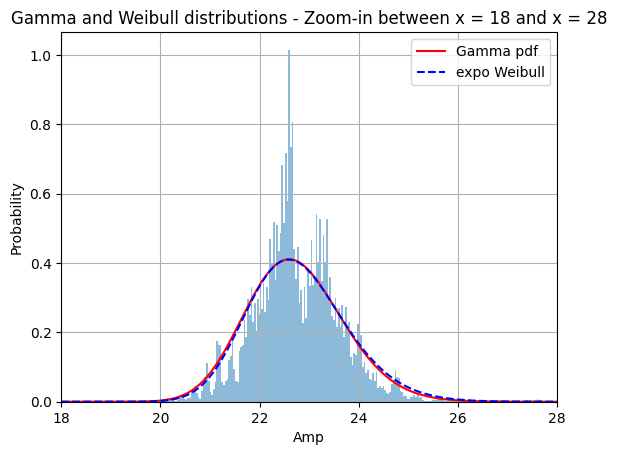

the loc of the gamma distribution is:  15.629113736275116
the loc of the exponentiated Weibull distribution is:  13.630835204446942

gamma log-likelihood : -119739.70951714725
expo weibull log-likelihood : -119762.9994407259

We choose the Gamma Distribution
The probability that we observe a peak of induced draft fan motor current above 30 Amp is 2.651745711901299e-09


In [70]:
# Data reading
variable = data['YFJ3_AI.AV_0#']
x =  np.linspace(variable.min(), variable.max(), 10000)

# Plot
plt.title("Gamma and Weibull distributions - Induced draft fan motor current")
plt.xlabel('Amp')
plt.ylabel('Probability')
plt.grid(True)

# Histogram
n, bins, patches = plt.hist(variable, bins=1000, density=True, alpha=0.5)

# Gamma distribution
alpha , loc, beta = sc.gamma.fit(variable)      # fitting
G = sc.gamma.pdf(x,loc=loc,a=alpha,scale=beta)  # evaluating for x
plt.plot(x, G,'r-', label='Gamma pdf')          # plot

# exponentiated Weibull distribution
exp , k , locexpo, lam = sc.exponweib.fit(variable)     # fitting
W = sc.exponweib.pdf(x,exp,k,locexpo,lam)               # evaluating for x
plt.plot(x, W,'b--', label='expo Weibull')              # plot

# Display
plt.legend()
plt.show()

# Zoomed-in plot between x = 18 and x = 28
plt.figure()
n, bins, patches = plt.hist(variable, bins=1000, density=True, alpha=0.5)
plt.title("Gamma and Weibull distributions - Zoom-in between x = 18 and x = 28")
plt.xlabel('Amp')
plt.ylabel('Probability')
plt.grid(True)
plt.plot(x, G,'r-', label='Gamma pdf')
plt.plot(x, W,'b--', label='expo Weibull')
plt.xlim((18,28))
plt.legend()
plt.show()

# Verification : locs >= 0
print("the loc of the gamma distribution is: ", loc)
print("the loc of the exponentiated Weibull distribution is: ", locexpo)
print("")

# log-likelihood computation
l_gamma = sc.gamma.logpdf(variable,loc=loc,a=alpha,scale=beta)
l_weibull = sc.exponweib.logpdf(variable,exp,k,locexpo,lam)

likelihoodgamma = np.sum(l_gamma)
likelihoodexpoweib = np.sum(l_weibull)

print("gamma log-likelihood : " + str(likelihoodgamma))
print("expo weibull log-likelihood : " + str(likelihoodexpoweib))
print("")

# Most appropriate distribution choice
if (likelihoodgamma <likelihoodexpoweib) :
    print("We choose the Exponentiated Weibull distribution")
    proba = 1-sc.exponweib.cdf(30,exp,k,locexpo,lam)
    print("The probability that we observe a peak of induced draft fan motor current above 30 Amp is "+ str(proba))

else:
    print("We choose the Gamma Distribution")
    proba = 1-sc.gamma.cdf(30,loc=loc,a=alpha,scale=beta)
    print("The probability that we observe a peak of induced draft fan motor current above 30 Amp is "+ str(proba))

### Comments

First of all, we have fitted our data with the Gamma and the exponentiated Weibull distributions. We just needed to make sure to have a null probability for negative values, which is the case because we have positive locs for both distributions.

Using the likelihood maximisation, we observed that the gamma distribution is the most appropriate one. We can see on the graph that the gamma distribution fits the histrograms a bit better than the exponentiated Weibull one.

The probability that we observe a peak of induced draft fan motor current above 30 Amp is 2.651745711901299e-09

### 5.b)
You want to set up a prediction algorithm of over- and under-heating (variable TE_8332A.AV_0). The aim is to anticipate any abnormal deviation to take necessary measures for driving back the temperature in $[530 ; 545]$. For this purpose, you will use the measure at time $ t - lag \times 5s$ for predicting the steam temperature at time t, where $lag$ is the number of 5-seconds lags. The model to fit is of the form:
$$Y_t = \beta_0 + \beta_1 X^1_{t-lag}+\beta_2 X^2_{t-lag}+...+\beta_n X^n_{t-lag}+\beta_{n+1} Y_{t-lag}+\varepsilon,\\$$
where $Y$ is the target variable (i.e. TE_8332A.AV_0), $(X^1,...,X^n)$ are all the explanatory variables (i.e. all the variables except TE_8332A.AV_0) and $\varepsilon \sim N(0,1).$

* Create a dataset such that for each date $t$ (each line), you have the target variable at time $t$ and the explanatory variables at time $t-lag \times 5s$.
* Use the OLS() function of the package statsmodels.api to perform the linear regression. 
* If an explanatory variable is not significant, remove it from your model.
* Test different lags and determine  the maximum number of lags, such that the probabilities that your model detects over- and under-heatings are above 90%

(**4 pts**)

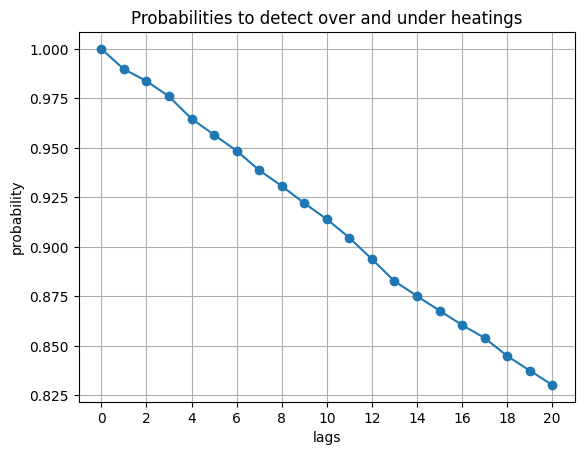

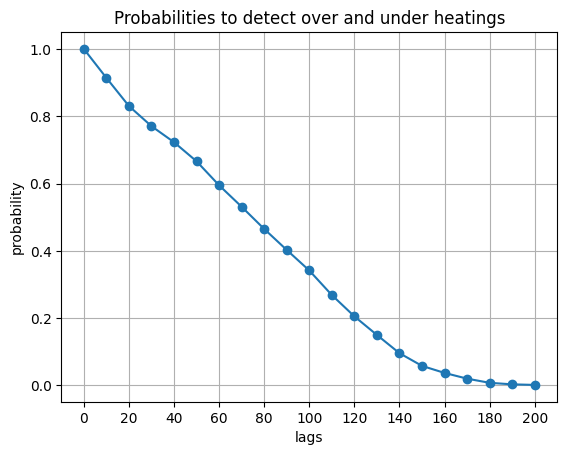

In [71]:
def create_dataset(lag):
    """
    create a lagged dataframe such that the explanatory variables are shifted by 'lag' relative to the target variable TE_8332A.AV_0

    @param lag : number of steps to shift the explanatory variables

    @return : the lagged dataframe such that : 
        - TE_8332A.AV_0#_t is at time t
        - all the explanatory variable are at time t-5*lag 

    """

    index = np.arange(lag)

    A = data[['date','TE_8332A.AV_0#']].drop(index).copy().reset_index(drop=True)
    A.columns = ['date','temperature']
    B = data.drop('date',axis=1).shift(lag).drop(index).copy().reset_index(drop=True)

    return pd.concat([A,B], axis=1)


def linear_reg(dataset, alpha=0.05):
    """
    Fit an Ordinary Least Squares (OLS) linear regression model and
    remove one by one all the  non significant variables based on their p-values (pvalue<0.05).

    @param dataset :  the dataFrame containing the target variable and the explanatory variables shifted by 'lag'

    @param alpha : the minimum p-value to remove an explanatory variable
     
    @return :  
        - the OLS model object that contains all the parameters of the regression
        - a list containing the removed variable
    """
    
    X = sm.add_constant(dataset.drop(['date','temperature'], axis=1))
    Y = dataset['temperature']

    removed_var = ['date','temperature']
    
    while True:
        results = sm.OLS(Y, X).fit()
        pvalues = results.pvalues.drop('const')

        max_pval = pvalues.max()
        if max_pval > alpha:
            var_to_remove = pvalues.idxmax()
            X = X.drop([var_to_remove],axis=1)
            removed_var.append(var_to_remove)
        else:
            break
    
    return results, removed_var



def make_ratio(lags) :
    """
    Compute the probability that the model detects under- and over-heatings, for all lag in lags

    @param lags : an array containing all lags that should be tested

    @return : 3 lists
        - the probability that the model detects under- and over-heatings for all lag in lags
        - the probability that the model detects under-heatings for all lag in lags
        - the probability that the model detects over-heatings for all lag in lags

    """

    ratios = []
    ratios_low = []
    ratios_high = []

    for lag in lags:

        dataset = create_dataset(lag)                                                       # laggued dataset creation
        results, removed_var = linear_reg(dataset)                                          # linear regression
        y_predict = results.predict(sm.add_constant(dataset.drop(removed_var,axis=1)))      # prediction

        N_low = 0       # total number of under-heating
        n_low = 0       # number of well-predicted under_heating
        N_high = 0      # total number of over-heating
        n_high = 0      # number of well-predicted over-heating

        for i in range(len(y_predict)):

            # Computation of N_low and n_low
            if dataset['temperature'].iloc[i] < 530 :
                N_low += 1
                if y_predict.iloc[i] < 530 :
                    n_low += 1
            
            # Computation of N_high and n_high
            elif dataset['temperature'].iloc[i] > 545 :
                N_high += 1
                if y_predict.iloc[i] > 545 :
                    n_high += 1
        
        N = N_low + N_high
        n = n_low + n_high

        ratio = n/N if N > 0 else np.nan
        ratios.append(ratio)

        ratio_low = n_low/N_low if N_low > 0 else np.nan
        ratios_low.append(ratio_low)

        ratio_high = n_high/N_high if N_high > 0 else np.nan
        ratios_high.append(ratio_high)

    return ratios, ratios_low, ratios_high


# tested lags : 0 to 20
lags1 = np.arange(21)
ratios1, ratios_low1, ratios_high1 = make_ratio(lags1)

# Plot for lags1 : 0 to 20
plt.plot(lags1,ratios1,marker='o')
plt.title("Probabilities to detect over and under heatings")
plt.xlabel('lags')
plt.xticks(np.arange(0, 21, 2))
plt.ylabel('probability')
plt.grid(True)
plt.show()


# tested lags : 0 to 200, with a step of 10
lags2 = np.arange(0,201,10)
ratios2, ratios_low2, ratios_high2 = make_ratio(lags2)

# Plot for lags2 : 0 to 200, with a step of 10
plt.plot(lags2,ratios2,marker='o')
plt.title("Probabilities to detect over and under heatings")
plt.xlabel('lags')
plt.xticks(np.arange(0, 201, 20))
plt.ylabel('probability')
plt.grid(True)
plt.show()

### Comments

When testing different lag values, we observe that the model becomes less accurate as the lag increases. In particular, when the lag is higher than 11, the probability of correctly detecting overheating drops below 90%. This means that most of the useful information to predict overheating is found within the last 55 seconds (11 × 5 s) before the event.

### 5.c)
Compare the probabilities that your model detects over- and under-heatings. (**1 pt**)

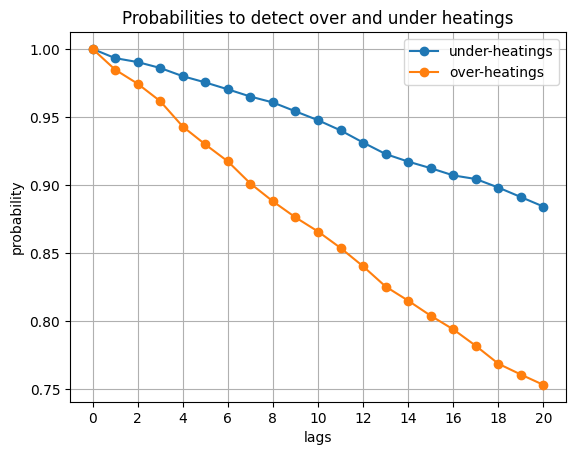

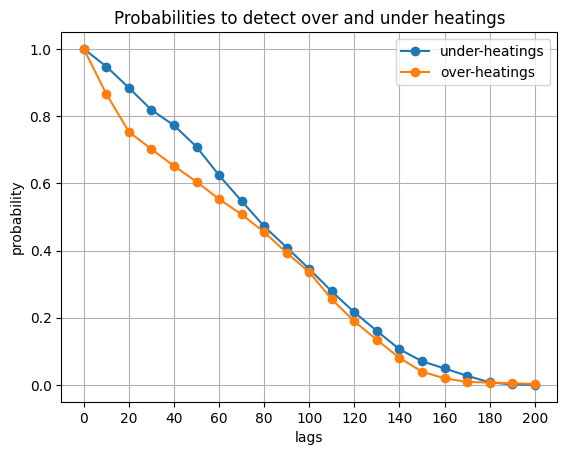

In [72]:
# Plot for lags from 0 to 20
plt.plot(lags1,ratios_low1, label='under-heatings',marker ='o')
plt.plot(lags1,ratios_high1,label='over-heatings',marker='o')
plt.title("Probabilities to detect over and under heatings")
plt.xlabel('lags')
plt.xticks(np.arange(0, 21, 2))
plt.ylabel('probability')
plt.legend()
plt.grid(True)
plt.show()


# Plot for lags from 0 to 200, with a step of 10
plt.plot(lags2,ratios_low2, label='under-heatings',marker ='o')
plt.plot(lags2,ratios_high2,label='over-heatings',marker='o')
plt.title("Probabilities to detect over and under heatings")
plt.xlabel('lags')
plt.xticks(np.arange(0, 201, 20))
plt.ylabel('probability')
plt.legend()
plt.grid(True)
plt.show()

### Comments

Overall, the probability of detecting underheating is higher than the probability of detecting overheating. Both probabilities decrease as the lag increases. After a lag of about 180 (900 seconds), the probabilities become almost zero, meaning the model can no longer detect over/underheating.